In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 10
eps_sublevels = percents = [0.1, 0.01]

alpha = 1 # proximal term coefficient

num_agents = num_packages = 200
num_fcs = 50

filename = "local_ap_N%d_%s_n%d_m%d"%(num_points, ",".join(list(map(str, eps_sublevels))), num_agents, num_fcs)

In [4]:
econ, A_ineq, b_ineq = mra.ap_data(num_packages, num_fcs)

b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [5]:
true_xp, true_xf, true_f, true_lamb, true_prob = mra.assignment_problem_milp_solution(num_packages, num_fcs, econ,  integer=False)
print(f"{true_f=}")

true_f=-90.29596235239258


In [6]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

0.12754546028411598

In [7]:
true_lamb.shape, true_xp.shape, true_xf.shape

((50,), (200, 50), (50,))

In [8]:
fun_agents_eps = {}
fun_agents_noisy_y = {}
for eps in percents:
    fun_agents_eps[eps] = []
    fun_agents_noisy_y[eps] = []
    for i in range(num_packages):
        fun_agents_eps[eps] += [lambda lamb_k, K, i=i: mra.cvx_package_agent_query_multiple_actions(lamb_k, i, num_fcs,
                                                                                    econ, eps_sublevel=eps, K=K, eps=0, return_best=True)]
        fun_agents_noisy_y[eps] += [lambda lamb_k, K, i=i: mra.cvx_package_agent_query_multiple_actions_noisy_prices(lamb_k, i, num_fcs,
                                                                                    econ, percent=eps, K=K, eps=0, return_best=True)]
    
    for i in range(num_packages, num_packages+num_fcs):
        fun_agents_eps[eps] += [lambda lamb_k, K, i=i: mra.fc_agent_query_multiple_actions(lamb_k, i-num_packages, 
                                                                            econ, eps_sublevel=eps, K=K, return_best=True)]
        fun_agents_noisy_y[eps] += [lambda lamb_k, K, i=i: mra.fc_agent_query_multiple_actions_noisy_prices(lamb_k, i-num_packages, 
                                                                            econ, percent=eps, K=K, return_best=True)]


fun_obj_val = lambda x_k: mra.assignment_problem_obj_val(x_k, num_packages, num_fcs, econ, integer=False)

# Localization

In [9]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

In [10]:
all_results_eps = {}
all_results_noisy_y = {}
for eps in percents:
    print(f"{eps=}")
    all_results_eps[eps]  = mra.price_localization_primal_recovery(fun_agents_eps[eps], fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]


    all_results_noisy_y[eps]  = mra.price_localization_primal_recovery(fun_agents_noisy_y[eps], fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]

eps=0.1
epoch=0, f_prec[-1]=4.01, f_xk[-1]=27.32, viol_prec=1.0278E+02, viol_xk=1.3706E+02, lamb_rel_diff=0.0000E+00, dist_x_bar_x[-1]=2.4756E-01
epoch=15, f_prec[-1]=-86.34, f_xk[-1]=-92.21, viol_prec=8.7581E-10, viol_xk=7.8628E+01, lamb_rel_diff=5.8849E-02, dist_x_bar_x[-1]=4.7123E-01
terminate with lamb_rel_diff=0.05884912861813359
epoch=0, f_prec[-1]=23.01, f_xk[-1]=27.32, viol_prec=1.3256E+02, viol_xk=1.3706E+02, lamb_rel_diff=0.0000E+00, dist_x_bar_x[-1]=3.2969E-02
epoch=50, f_prec[-1]=-89.50, f_xk[-1]=-91.15, viol_prec=9.7299E+00, viol_xk=7.1921E+01, lamb_rel_diff=5.4798E-02, dist_x_bar_x[-1]=5.2642E-01
epoch=71, f_prec[-1]=-89.50, f_xk[-1]=-91.15, viol_prec=9.1464E-10, viol_xk=6.2050E+01, lamb_rel_diff=4.7269E-02, dist_x_bar_x[-1]=4.1227E-01
terminate with lamb_rel_diff=0.04726876555948822
eps=0.01
epoch=0, f_prec[-1]=17.57, f_xk[-1]=27.32, viol_prec=1.2622E+02, viol_xk=1.3706E+02, lamb_rel_diff=0.0000E+00, dist_x_bar_x[-1]=7.8292E-02
epoch=50, f_prec[-1]=-90.69, f_xk[-1]=-91.1

In [11]:
eps = max(percents)
if len(all_results_noisy_y[eps]["subopt_xk"]) > len(all_results_eps[eps]["subopt_xk"]):
    all_res = all_results_noisy_y[eps]
else:
    all_res = all_results_eps[eps]

In [13]:
for i, eps in enumerate(percents):
      print(np.array(all_res["viol_primal_xk"])[-1] ,
      "sub_eps", np.array(all_results_eps[eps]["viol_primal_mra_xk"])[-1] ,
      "noisy_y", np.array(all_results_noisy_y[eps]["viol_primal_mra_xk"])[-1] )

29.175008909745763 sub_eps 5.622964680679354e-10 noisy_y 5.587214359272697e-10
29.175008909745763 sub_eps 4.707374855344826e-10 noisy_y 0.9363222982746815


In [ ]:
import pickle

with open(f"results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)

In [6]:
import pickle

# with open(f"results/{filename}_dict.pkl", "wb") as file:
#     pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
with open(f"results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
    all_results_eps = res["eps"]
    all_results_noisy_y = res["noisy_y"]
    eps = max(percents)
    if len(all_results_noisy_y[eps]["subopt_xk"]) > len(all_results_eps[eps]["subopt_xk"]):
        all_res = all_results_noisy_y[eps]
    else:
        all_res = all_results_eps[eps]
# res["eps"].keys()

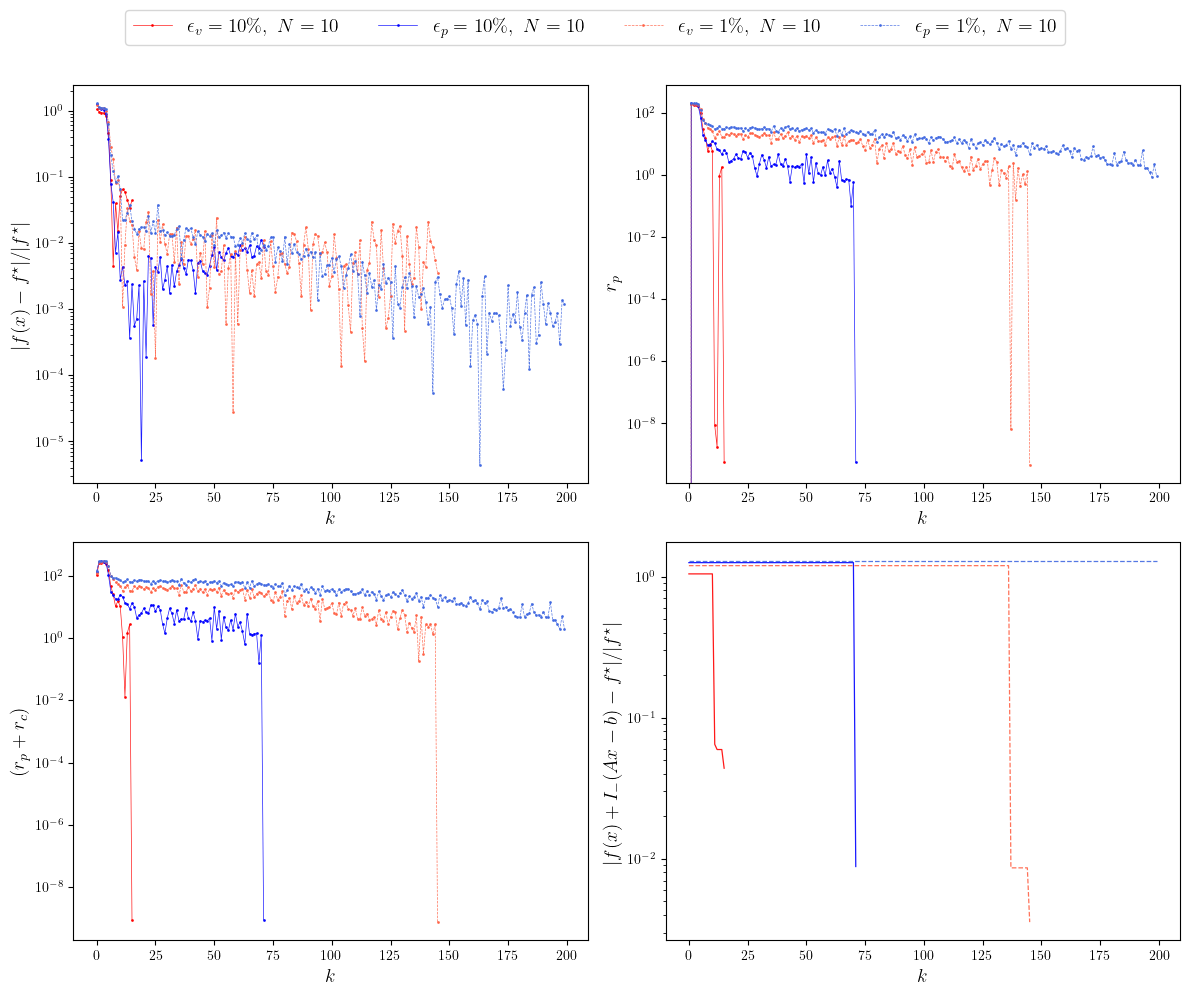

In [8]:
mra.plot_eps_all_metrics_4x(all_results_eps, all_results_noisy_y, num_points, true_f, b_norm, percents, filename)